In [11]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
CUR_VALIDATORS = 606_797

#### Scatter Unique Participation

In [3]:
exp_count = 1_000
num_periods = 365 * 5 

results = []
unique_validators_epoch = dict()

for i in range(0,exp_count):
    validator_dict = {i: 0 for i in range(0,CUR_VALIDATORS)}
    
    for periods in range(0,num_periods):
        
        random.seed()
        drawn_committee = random.sample(range(CUR_VALIDATORS),512)
        for d in drawn_committee:
            validator_dict[d] += 1
        
        unique_validators_epoch[periods] = np.array([i > 0 for i in validator_dict.values()]).sum()
        
    results.append(unique_validators_epoch.copy())


In [4]:
df = pd.DataFrame(
    range(0,len(results[0])),
    index=range(0,len(results[0]))
).rename(columns={0: 'periods'}).set_index('periods')

for i in range(0,len(results)):
    df[f'epoch_{i}'] = results[i]

In [574]:
df_stats = pd.DataFrame()
df_stats['mean_value'] = df[df.columns[df.columns.str.startswith('epoch')]].mean(axis=1)
df_stats['std_value'] = df[df.columns[df.columns.str.startswith('epoch')]].std(axis=1)
df_stats['min_value'] = df[df.columns[df.columns.str.startswith('epoch')]].min(axis=1)
df_stats['max_value'] = df[df.columns[df.columns.str.startswith('epoch')]].max(axis=1)

df_stats['range'] = df_stats['max_value'] - df_stats['min_value']
df_stats['lower_range'] = df_stats['min_value'] - df_stats['mean_value']
df_stats['upper_range'] = df_stats['max_value'] - df_stats['mean_value']

### Explore experiment moments

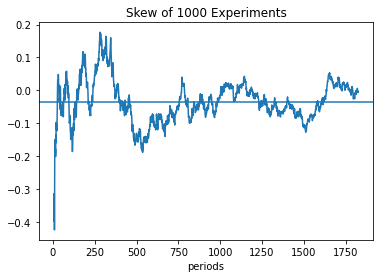

In [526]:
skew_df = df[df.columns[df.columns.str.startswith('epoch')]].skew(axis=1)
skew_df[5:].plot(title='Skew of 1000 Experiments')
plt.axhline(skew_df.mean());

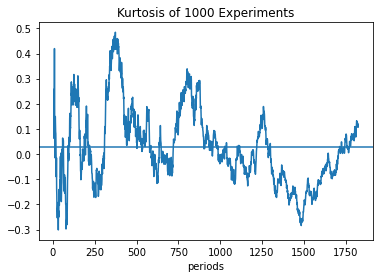

In [525]:
kurt_df = df[df.columns[df.columns.str.startswith('epoch')]].kurt(axis=1)
kurt_df[5:].plot(title='Kurtosis of 1000 Experiments')
plt.axhline(kurt_df.mean())

In [517]:
def exp_fit(df, result_name = 'exponential_fit'):
    df = df.copy()
    p = np.polyfit(df.index,np.log(df),1) # Log Linear fit
    a = np.exp(p[1])
    b = p[0]
    df['exponential_fit'] = a*np.exp(df.index*b)
    return df

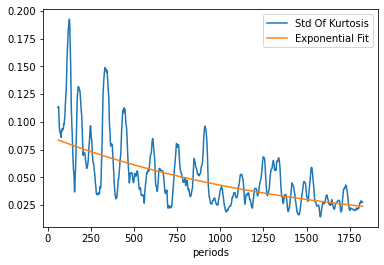

In [527]:
fig, ax = plt.subplots()

exp_fit(kurt_df.rolling(50).std()[60:].to_frame()).plot(ax = ax)
ax.legend(['Std Of Kurtosis','Exponential Fit']);

The average kurtosis of the distribution is ~0.1, while a normal distribution's kurtosis is 3. This tell us that the sample distribution is very polykurtic - meaning it deviates significantly from a normal distribution in that it has much lighter tails.

A normal distribution has a kurtosis of 3, so our distribution with 
a kurtosis < .1 - is very platykurtic, it follows that 1 standard deviation a large part of the data

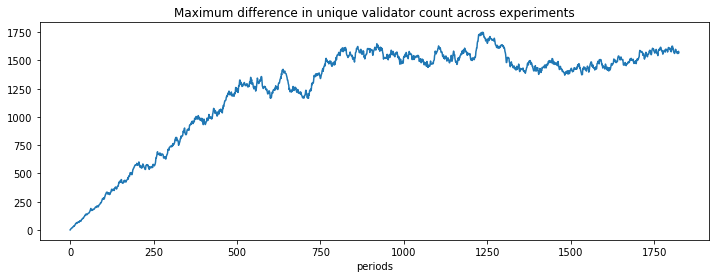

In [555]:
df_stats['range'].plot(
    title='Maximum difference in unique validator count across experiments',
    figsize=(12,4)
);

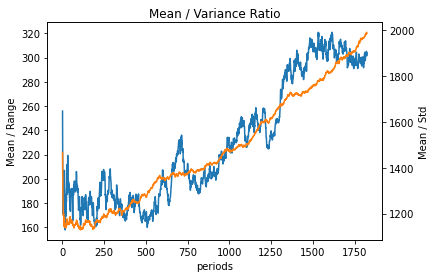

In [568]:
(df_stats['mean_value'] / df_stats['range']).plot(
    title='Mean / Variance Ratio',
    ylabel='Mean / Range'
)
(df_stats['mean_value'] / df_stats['std_value']).plot(
    secondary_y=True,
    ylabel='Mean / Std'
);

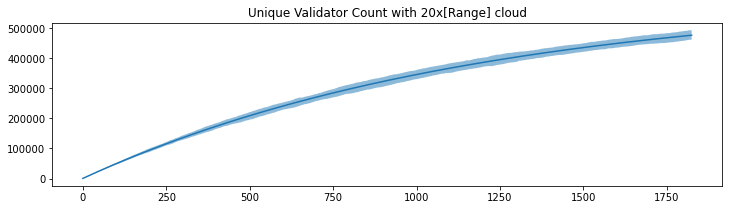

In [572]:
plt.figure(figsize=(12,3))
plt.plot([i for i in range(0,1825)], df_stats['mean_value'])
plt.fill_between(
    [i for i in range(0,1825)],
    df_stats['mean_value'] + 20*df_stats['lower_range'],
    df_stats['mean_value'] + 20*df_stats['upper_range']
    ,alpha=.5
)
plt.title("Unique Validator Count with 20x[Range] cloud")
plt.show()

I've plotted 20x Range for Illustrative purposes, otherwise the deviation is so small that we don't see the variance on the plot. Maximum range has been chosen, since standard deviation isn't a good measure in heavily polykurtic distributions.

Even across 1000 experiements there is a very small range of values for the total number of unique validators to fall within. A potential safeguard that can be implemented is to check if this metric is in some predefined bounds for the given syncing range. 

To avoid crossing this statistical bound, the attacker would be forced to control a significant majority of the exited validators, making this vector of attack much more expensive. 